In [1]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision.transforms import v2
from torchvision.utils import make_grid

from torchinfo import summary

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [3]:
BATCH_SIZE = 32

In [4]:
transform = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])
dataset = datasets.MNIST(root='./mnist/', train=True, transform=transform)

torch.Size([32, 1, 28, 28])
tensor([9, 0, 2, 8, 1, 5, 8, 0, 8, 1, 3, 3, 5, 8, 2, 3, 4, 4, 6, 5, 2, 1, 6, 7,
        6, 9, 9, 5, 6, 2, 3, 7])


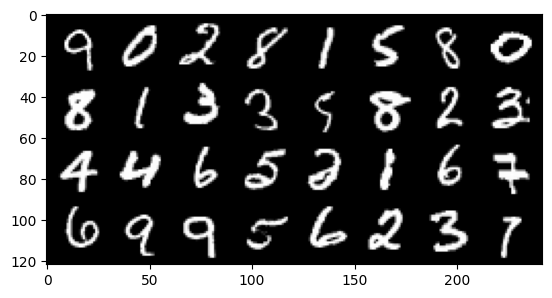

In [5]:
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

for images, labels in dataloader:
    break

print(images.shape)
print(labels)

plt.imshow(make_grid(images)[0], cmap='gray')

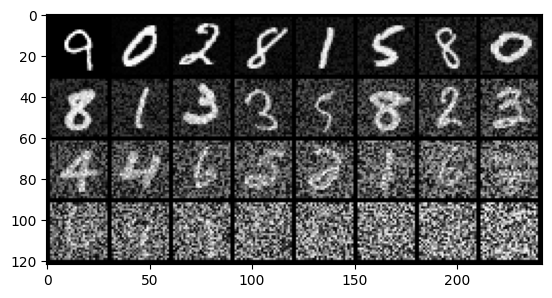

In [6]:
def corrupt(images: torch.Tensor, amount: torch.Tensor) -> torch.Tensor:
    noise = torch.rand_like(images)
    amount = amount.view(-1, 1, 1, 1)
    return images * (1 - amount) + noise * amount


amount = torch.linspace(0, 1, BATCH_SIZE)
corrupted_images = corrupt(images, amount)
plt.imshow(make_grid(corrupted_images)[0], cmap='gray')

In [7]:
class UNetConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layers(x)


class LightUNet(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()

        self.conv1 = UNetConv(in_channels, 32)
        self.conv2 = UNetConv(32, 64)
        self.conv3 = UNetConv(64, 128)
        self.conv4 = UNetConv(128, 64)
        self.conv5 = UNetConv(64, 32)

        self.deconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.deconv2 = nn.ConvTranspose2d(64, 32, 2, stride=2)

        self.outconv = nn.Conv2d(32, out_channels, 1)
        self.maxpool = nn.MaxPool2d(2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x1 = self.conv1(x)
        x2 = self.conv2(self.maxpool(x1))
        x = self.conv3(self.maxpool(x2))
        x = self.conv4(torch.cat((self.deconv1(x), x2), dim=1))
        x = self.conv5(torch.cat((self.deconv2(x), x1), dim=1))
        
        return self.sigmoid(self.outconv(x))


model = LightUNet(1, 1)
x = torch.randn(16, 1, 28, 28)
assert x.shape == model(x).shape

summary(model, input_size=(BATCH_SIZE, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
LightUNet                                [32, 1, 28, 28]           --
├─UNetConv: 1-1                          [32, 32, 28, 28]          --
│    └─Sequential: 2-1                   [32, 32, 28, 28]          --
│    │    └─Conv2d: 3-1                  [32, 32, 28, 28]          320
│    │    └─BatchNorm2d: 3-2             [32, 32, 28, 28]          64
│    │    └─ReLU: 3-3                    [32, 32, 28, 28]          --
│    │    └─Conv2d: 3-4                  [32, 32, 28, 28]          9,248
│    │    └─BatchNorm2d: 3-5             [32, 32, 28, 28]          64
│    │    └─ReLU: 3-6                    [32, 32, 28, 28]          --
├─MaxPool2d: 1-2                         [32, 32, 14, 14]          --
├─UNetConv: 1-3                          [32, 64, 14, 14]          --
│    └─Sequential: 2-2                   [32, 64, 14, 14]          --
│    │    └─Conv2d: 3-7                  [32, 64, 14, 14]          18,496
│    │ 

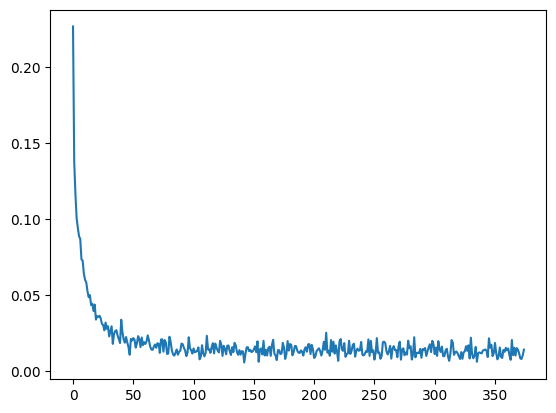

In [9]:
model = LightUNet(1, 1).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.MSELoss()

N_EPOCHS = 1

loss_history = []

for _ in range(N_EPOCHS):
    for i, (images, _) in enumerate(dataloader):
        images = images.to(DEVICE)
        amount = torch.rand(BATCH_SIZE).to(DEVICE)
        corrupted_images = corrupt(images, amount)

        optimizer.zero_grad()
        restored_images = model(corrupted_images)
        loss = loss_func(restored_images, images)
        loss.backward()
        optimizer.step()

        if i % 5 == 0:
            loss_history.append(loss.item())

            clear_output(wait=True)
            plt.plot(loss_history)
            plt.show()

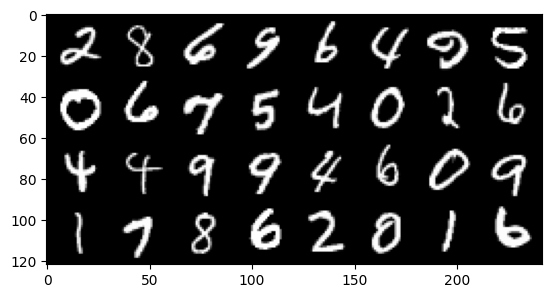

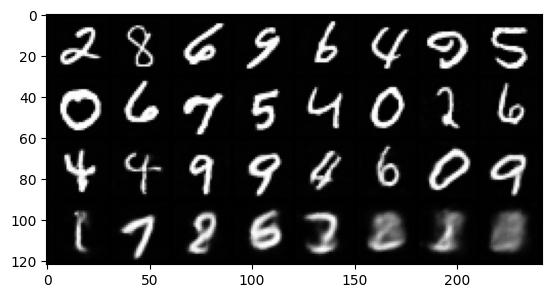

In [10]:
model.eval()

for images, label in dataloader:
    break

plt.imshow(make_grid(images)[0], cmap='gray')
plt.show()

amount = torch.linspace(0, 1, BATCH_SIZE)
corrupted_images = corrupt(images, amount).to(DEVICE)

with torch.no_grad():
    restored_images = model(corrupted_images).detach().cpu()

plt.imshow(make_grid(restored_images)[0], cmap='gray')
plt.show()